# Irradiance Transposition

A notebook to compute plane-of-array irradiance over varying time integrations using irradiance data from the Sheffield Solar testbed.

*Jamie Taylor, A Buckley*

*First Authored: 2019-11-05*

*Revised: 2020-08-28*


---



## Setup
Install the necessary Python packages:

In [ ]:
!pip install numpy pandas>1.0 matplotlib pvlib -q xlrd

Import some modules:

In [ ]:
from datetime import datetime
import pandas as pd
import numpy as np
import pvlib
import matplotlib.pyplot as plt

Change this setting to make plots bigger or smaller:

In [ ]:
plt.rcParams['figure.dpi'] = 120

Hard code some inputs as variables (don't do this in production code!):

In [ ]:
lat = 53.23
lon = -1.15
ori = 225
tilt = 35

## Functions

A function to load the testbed data:

In [ ]:
def load_testbed_data():
    """
    Load pyranometer data from a CSV file. This data file includes measured GHI and horizontal
    diffuse radiation.
    """
    url = "https://raw.githubusercontent.com/alastairbuckley/PHY6000/master/ss_testbed_irrad_2012.csv"
    data = pd.read_csv(url, parse_dates=["dateandtime"])
    # Use the col_mapper dictionary to rename cols
    col_mapper = {"dateandtime": "timestamp", "GHI": "ghi", "DHI": "dhi"}
    data.rename(columns=col_mapper, inplace=True)
    # Set the timestamp as the index of the dataframe
    data.set_index("timestamp", inplace=True)
    # Tell pandas our timestamps are UTC
    data = data.tz_localize(tz="UTC")
    return data
load_testbed_data()

ghi  dhi
timestamp                          
2012-01-01 00:01:00+00:00  1.9  1.3
2012-01-01 00:03:00+00:00  1.1  0.0
2012-01-01 00:05:00+00:00  1.1  0.0
2012-01-01 00:09:00+00:00  1.9  1.3
2012-01-01 00:11:00+00:00  1.1  0.0
...                        ...  ...
2012-12-29 06:06:00+00:00  1.1  0.0
2012-12-29 06:08:00+00:00  1.9  1.3
2012-12-29 06:10:00+00:00  2.3  1.3
2012-12-29 06:12:00+00:00  3.2  2.5
2012-12-29 06:14:00+00:00  2.9  1.4

[249209 rows x 2 columns]

A function to simulate Extra-atmospheric irradiance:

In [ ]:
def simulate_eai(start, end, lat, lon, freq="1min"):
    """Simulate EAI for a given time range, location and frequency."""
    # Create a DatetimeIndex of minutely timestamps
    times = pd.date_range(start=start, end=end, freq=freq, tz="UTC")
    # Create a Location object
    loc = pvlib.location.Location(lat, lon, tz="UTC", altitude=130, name="Hicks Bulding Lower Roof")
    # Compute the solar position for the times
    solpos = loc.get_solarposition(times)
    # Simulate EAI for the times (not corrected for location)
    eai_global = pvlib.irradiance.get_extra_radiation(times)
    # Correct for location
    eai = eai_global * np.cos(np.radians(solpos["apparent_zenith"]))
    eai[eai < 0] = 0
    # Convert EAI to a Dataframe with named column (helpful later)
    eai = pd.DataFrame(eai, columns=["eai"])
    eai_global = pd.DataFrame(eai_global, columns=["eai_global"])
    eai = eai.merge(eai_global, left_index=True, right_index=True)
    return eai, solpos


Functions to produce our plots later:


In [ ]:
def plot_irradiance_timeseries(irr, inplane):
    """Plot GTI and GHI time series."""
    # Create a new figure
    fig = plt.figure(figsize=(10,10))
    # Add title
    fig.suptitle("GTI vs GHI")
    # Plot GHI
    ax = irr["ghi"].plot(label="GHI", linewidth=1)
    # Plot GTI
    inplane["poa_global"].plot(ax=ax, label="GTI", linewidth=1, dashes = [1,1])
    # Label the axes
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Irradiance (W/m^2)')
    # Show legend entries
    ax.legend()
    plt.show()

def plot_kd(erbs, irr):
    """Create a new figure to plot actual and modelled kd."""
    fig = plt.figure()
    ax = fig.add_subplot()
    # Add title
    fig.suptitle("Modelled vs actual diffuse fraction")
    ## Plot kd_erbs vs kd
    actual_kd = irr["dhi"] / irr["ghi"]
    modelled_kd = erbs["dhi"] / irr["ghi"]
    plt.scatter(actual_kd, modelled_kd, edgecolor=None, alpha=0.3)
    # Label the axes
    ax.set_xlabel('Actual kd')
    ax.set_ylabel('Modelled kd')
    plt.show()

def plot_gti_vs_ghi(irr, inplane):
    """Plot GTI vs GHI."""
    # Create a new figure
    fig = plt.figure()
    ax = fig.add_subplot()
    # Add title
    fig.suptitle("GTI vs GHI")
    # Plot
    plt.scatter(irr["ghi"], inplane["poa_global"], edgecolor=None, alpha=0.3)
    ax.set_xlabel('GHI (W/m2)')
    ax.set_ylabel('GTI (W/m2)')
    plt.show()




## Bring it all together...

In [ ]:
# Load the pyranometer data from CSV
irr = load_testbed_data()

# Determine the start/end date based on the pyran data just loaded
start = irr.index[0]
end = irr.index[-1]

# Simulate the minutely EAI for the same period
eai, solpos = simulate_eai(start, end, lat, lon, '1min')

# Merge the irr, eai and solpos df's so only indices in both are kept
irr_ = irr.merge(solpos, left_index=True, right_index=True).merge(eai, left_index=True,
                                                                  right_index=True)

# Use the Erbs model to estimate diffuse fraction
erbs = pvlib.irradiance.erbs(irr_["ghi"], irr_["zenith"], irr_.index)

# Transpose to the inclined plane
inplane = pvlib.irradiance.get_total_irradiance(tilt, ori, irr_["zenith"], irr_["azimuth"],
                                                erbs["dni"], irr_["ghi"], erbs["dhi"],
                                                irr_["eai_global"], surface_type="urban",
                                                model="haydavies")


## Plot our results

Minutely irradiance time-series:

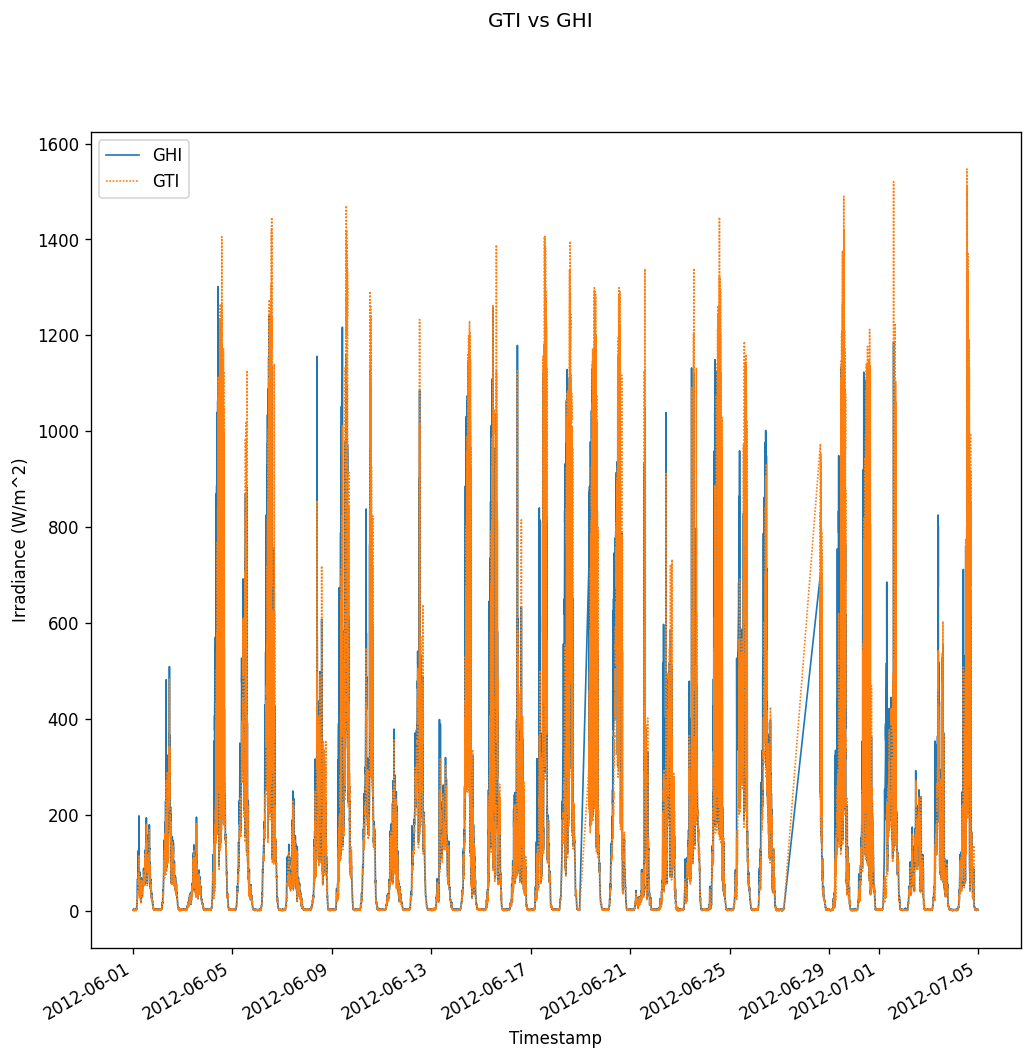

In [ ]:
plot_irradiance_timeseries(irr_.loc["2012-06-01":"2012-07-04"], inplane.loc["2012-06-01":"2012-07-04"])



---


Minutely diffuse fraction (kd), modelled vs actual:

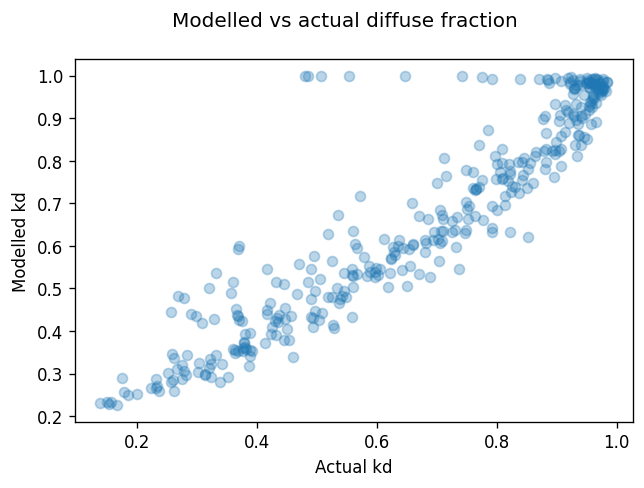

In [ ]:
irr_ = irr_.resample('D').mean()
erbs = erbs.resample('D').mean()

plot_kd(erbs, irr_)



---


Minutely Global Tilted Irradiance (GTI) vs Global Horizontal Irradiance (GHI):

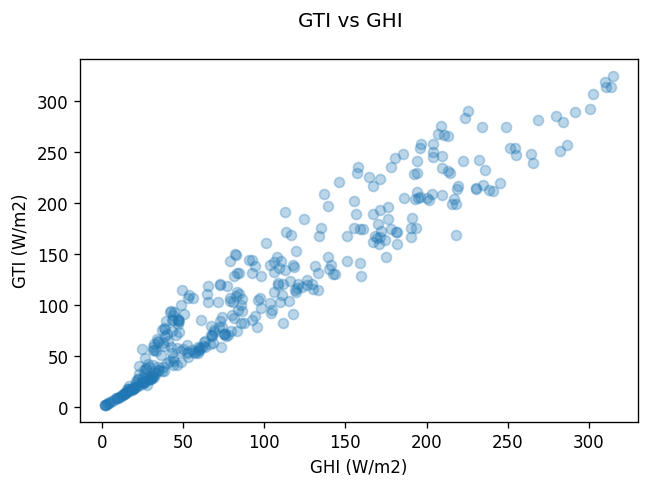

In [ ]:
inplane = inplane.resample('D').mean()

plot_gti_vs_ghi(irr_, inplane)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


ghi        dhi  ...        KT        kd
2012-01-01 00:00:00+00:00  13.850852  12.768466  ...  0.196978  0.921854
2012-01-02 00:00:00+00:00  38.961250  12.892083  ...  0.561798  0.330895
2012-01-03 00:00:00+00:00  16.365508  12.856606  ...  0.234111  0.785592
2012-01-04 00:00:00+00:00  15.115716  14.046732  ...  0.213474  0.929280
2012-01-05 00:00:00+00:00  33.908484  15.944089  ...  0.473768  0.470209
...                              ...        ...  ...       ...       ...
2012-12-24 00:00:00+00:00   8.778303   7.785396  ...  0.132674  0.886891
2012-12-25 00:00:00+00:00  24.770474  21.083148  ...  0.372723  0.851140
2012-12-26 00:00:00+00:00  27.235285  15.550000  ...  0.382716  0.570951
2012-12-27 00:00:00+00:00  15.415855  13.965786  ...  0.230328  0.905936
2012-12-28 00:00:00+00:00  16.141111  14.736528  ...  0.240190  0.912981

[352 rows x 12 columns]

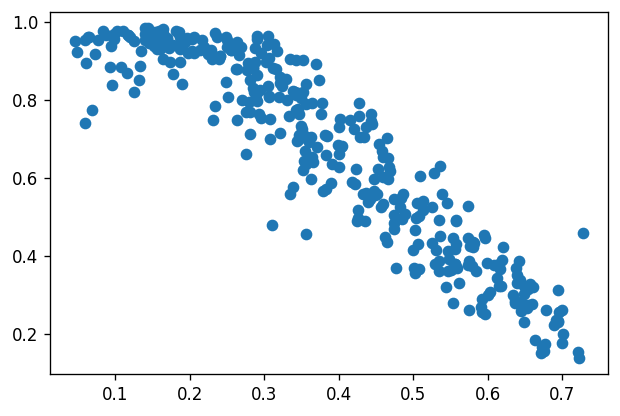

In [ ]:
irr_day = irr_[irr_['eai'] != 0]
irr_day['KT'] = irr_day['ghi']/irr_day['eai']
irr_day['kd'] = irr_day['dhi']/irr_day['ghi']
irr_day = irr_day[irr_day['KT'] < 1.5]
plt.scatter(irr_day['KT'], irr_day['kd'])
irr_day

Automating the analysis process:

In [ ]:
def run_analysis():
  

SyntaxError: ignored

Importing all historic data, then sorting into URN number

In [ ]:
from google.colab import drive
from dateutil.parser import parse
import glob
import os
drive.mount("/content/gdrive", force_remount=True)
filepath = '/content/gdrive/MyDrive/Microgen data/CSVs/'
all_files = glob.glob(os.path.join(filepath, '*.csv'))

full_data = pd.DataFrame()

for filename in sorted(all_files):
  df = pd.read_csv(filename)

  df = df[pd.to_numeric(df['URN'], errors='coerce').notnull()]
  df.set_index('URN', inplace = True)
  df.drop(df.columns[[-2, -1]], axis=1, inplace=True)
  df.index = df.index.astype(int)

  
  if filename[-10:] > '201703.csv':
    df.columns =  pd.to_datetime(df.columns, format='%b %Y')
  else:
    df.columns =  pd.to_datetime(df.columns, format='%b %y')
  trans = df.T
  frame = df
  cols_to_use = full_data.columns.difference(frame.columns)
  full_data = frame.merge(full_data[cols_to_use], left_index=True, right_index=True, how='outer')

full_data.sort_index(axis = 1)

Mounted at /content/gdrive


2012-03-01  2012-04-01  2012-05-01  ...  2020-01-01  2020-02-01  2020-03-01
URN                                       ...                                    
1             92        73.0       111.0  ...         NaN         NaN         NaN
2            NaN         NaN         NaN  ...         NaN         NaN         NaN
3             67        93.0       177.0  ...    6.488606   21.257290   76.783939
4             98        80.0       121.0  ...   27.626263   46.313131   93.232323
5             73        81.0        92.0  ...         NaN         NaN         NaN
...          ...         ...         ...  ...         ...         ...         ...
45195        NaN         NaN         NaN  ...   13.215216   19.614543   55.529705
45202        NaN         NaN         NaN  ...   27.657143   46.257143   97.714286
45207        NaN         NaN         NaN  ...   19.926355   42.619458   96.678325
45208        NaN         NaN         NaN  ...    6.395101   30.524595   75.386426
45220        NaN         NaN         NaN  ...   33.905000   61.035000  103.210000

[7171 rows x 97 columns]

In [ ]:
frame = df.drop(df[isinstance(df['URN'], int)])
print(frame)
frame.index = frame['URN']

for time in list(frame):
  name = datetime.strptime(time,'%b %y')
  print(name)


KeyError: ignored

In [ ]:
full_data.columns = sorted(full_data)
full_data

2012-03-01  2012-04-01  2012-05-01  ...  2020-01-01  2020-02-01  2020-03-01
URN                                        ...                                    
1       12.828468         NaN         NaN  ...         NaN         NaN    9.269551
2             NaN         NaN         NaN  ...         NaN         NaN         NaN
3        5.144033   21.871944   44.717285  ...   30.375165   16.608044    3.692740
4       29.949495   61.969697   86.313131  ...   74.292929   32.828283   23.686869
5             NaN         NaN         NaN  ...         NaN         NaN         NaN
...           ...         ...         ...  ...         ...         ...         ...
45195         NaN   21.075096   47.008904  ...         NaN         NaN         NaN
45202   27.485714   61.200000   84.828571  ...         NaN         NaN         NaN
45207   23.078571   65.356897   76.873892  ...         NaN         NaN         NaN
45208   16.088657   38.182832   56.073639  ...         NaN         NaN         NaN
45220   42.950000   76.365000   83.205000  ...         NaN         NaN         NaN

[7171 rows x 97 columns]

Aside from sheet issue, will need to address different month headers (e.g. Jan vs. Jan 2019) and cut off data outside of calendar year. Should only require 1 quarterly report per year, i.e. March 2014-March 2020 (7 files, overkill? Maybe)